In this notebook, we will use regression algorithms to predict the number of rented bikes for a given day

### Load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

seed=99
random.seed(seed)
np.random.seed(seed)

In [17]:
rental = pd.read_csv('data/rental.csv')

#### Preprocessing

Usually, standardization and normalization may be used on the independent variables as some machine learning algorithm is sensitive to the scale and distribution of the data such as SVM and linear regression. Scaling issues may result in features with larger values having more importance than others and ignore the features with lower values, impacting the model performance.

From our EDA phase, we do not see any significant scaling issues, even though some of the features with numerical label encoding do have higher values.

# Predictive modeling

Standardization function is copied from PS4:

In [3]:
import numpy as np

def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [18]:
from sklearn.model_selection import train_test_split

X = rental.loc[:, rental.columns != 'cnt']
y = rental['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X.head()

,mnth,hr,weekday,temp,atemp,hum,windspeed,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,1,0,6,0.24,0.2879,0.81,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1,1,6,0.22,0.2727,0.80,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1,2,6,0.22,0.2727,0.80,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1,3,6,0.24,0.2879,0.75,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1,4,6,0.24,0.2879,0.75,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


## Method 1: Multiple Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
score = lin_reg.score(X_train, y_train)
print(f'Predictive score on training data {score:.4f}')

score = lin_reg.score(X_test, y_test)
print(f'Predictive score on test data {score:.4f}')

Predictive score on training data 0.3477
Predictive score on test data 0.3646


The linear regression model provides us with a baseline which we can compare our other predictive algorithms on. This model got a score of 0.34 on the training data and 0.36 on the test set.

The score metric returns the R-squared value which describes how much of the variance the model is able to explain. We will use this metric throughout the notebook to compare the models deciding which has the best goodness of fit.

## Method 2. Gradient Boosting

#### Default model

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(random_state=seed)

# Fit the model and make prediction
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)

# Evaluate the model
cross_score = np.mean(cross_val_score(gbm, X_train, y_train, cv=10))
train_score = gbm.score(X_train, y_train)
test_score = gbm.score(X_test, y_test)


print('Training set {:.4f}'.format(train_score))
print('Cross-validated set: {:.4f}'.format(cross_score))
print('Test set: {:.4f}'.format(test_score))

Training set 0.7909
Cross-validated set: 0.7859
Test set: 0.7862


#### Finetuned model
Use a grid search algorithm to find the best hyperparameters for the gradient boosting algorithm.

In [21]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [2, 5, 6, 7, 9, 11],
    'n_estimators': [10, 50, 100],
    'min_samples_leaf': [1, 3, 5, 7, 9]
}

gbm = GradientBoostingRegressor(random_state=seed)

cv_search = GridSearchCV(gbm, param_grid, cv=5, verbose=True, n_jobs=-1).fit(X_train, y_train)
print("best parameters:", cv_search.best_params_)
best parameters: {'learning_rate': 0.1, 'max_depth': 9, 'min_samples_leaf': 9, 'n_estimators': 100}

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
best parameters: {'learning_rate': 0.1, 'max_depth': 9, 'min_samples_leaf': 9, 'n_estimators': 100}
CPU times: user 4.81 s, sys: 1.03 s, total: 5.85 s
Wall time: 3min 19s


In [22]:
print('Training set {:.4f}'.format(cv_search.best_estimator_.fit(X_train, y_train).score(X_train, y_train)))
print('Cross-validated set: {:.4f}'.format(cv_search.best_score_))
print('Test set: {:.4f}'.format(cv_search.best_estimator_.score(X_test, y_test)))

Training set 0.9455
Cross-validated set: 0.8775
Test set: 0.8798


The first model was trained using the default parameters of the gradient boosting algorithm and got a significant higher score than the multiple regression baseline model with an increase from 0.36 to 0.79 on the test set.

Due to the performance of the gradient boosting algorithm, we decided to finetune the hyperparameters to see if we could get a better performance. After using grid search to test out combinations of different parameters we got a result of 0.9455 on the training set, 0.8775 on cross-validation, and 0.8798 on the test set with the following parameters:
best parameters: {'learning_rate': 0.1, 'max_depth': 9, 'min_samples_leaf': 9, 'n_estimators': 100}

## Method 3. Decision Trees

#### Default model

In [25]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(random_state=seed)

# Fit the model and make prediction
dtr.fit(X_train, y_train)

# Evaluate the model
cross_score = np.mean(cross_val_score(dtr, X_train, y_train, cv=10))
train_score = dtr.score(X_train, y_train)
test_score = dtr.score(X_test, y_test)

print('Training set {:.4f}'.format(train_score)) 
print('Cross-validated score: {:.4f}'.format(cross_score.mean()))
print('Test set {:.4f}'.format(test_score))

Training set 0.9999
Cross-validated score: 0.7471
Test set 0.7647


The decision tree model with default parameters got a better score than the default gradient boosting alternative, but performed worse than the fine-tuned gradient boosting model. The performance on the training set is also significant better than on the test set. This difference may indicate an overfit on the training set.

#### Fine-tuning of the decision tree

In [26]:
param_grid = {
    'max_depth': [2, 5, 6, 7, 9, 11],
    'min_samples_leaf': [1, 3, 5, 7, 9]
}

dt = DecisionTreeRegressor(random_state=seed)

cv_search = GridSearchCV(dt, param_grid, cv=5, verbose=True, n_jobs=-1).fit(X_train, y_train)
print("best parameters:", cv_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
best parameters: {'max_depth': 11, 'min_samples_leaf': 9}


In [27]:
print('Training set {:.4f}'.format(cv_search.best_estimator_.fit(X_train, y_train).score(X_train, y_train)))
print('Cross-validated score: {:.4f}'.format(cv_search.best_score_))
print('Test set: {:.4f}'.format(cv_search.best_estimator_.score(X_test, y_test)))

Training set 0.8590
Cross-validated score: 0.8112
Test set: 0.8131


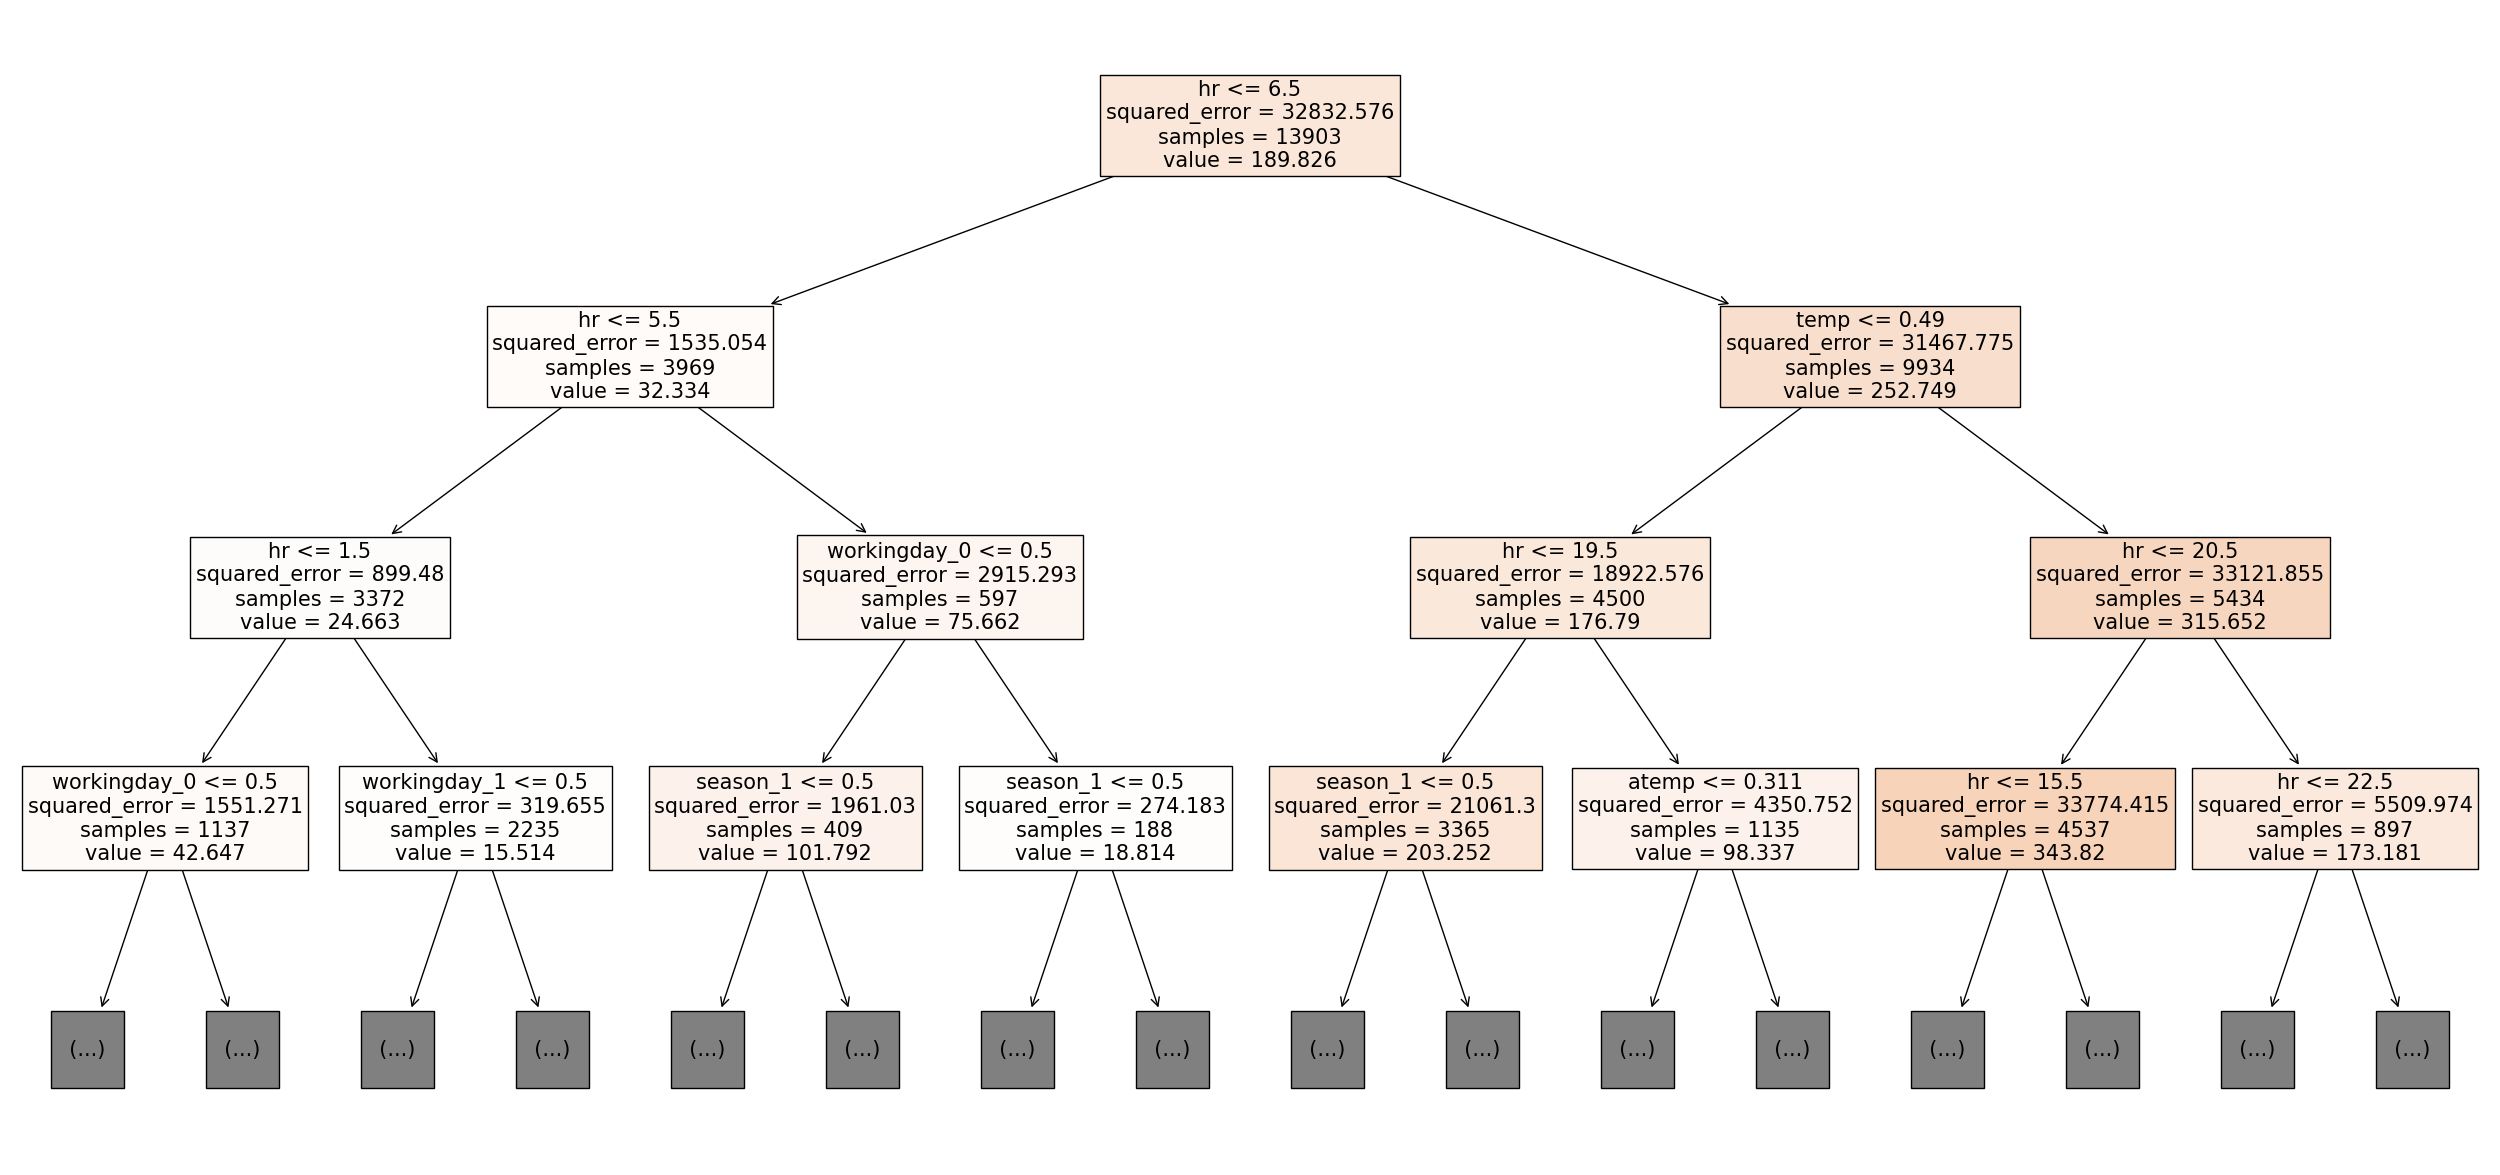

In [28]:
from sklearn.tree import plot_tree
import seaborn as sns

# Plot the decision tree
fig = plt.figure(figsize=(32,15))
plot_tree(dtr, fontsize=15, max_depth=3, feature_names=X_train.columns, class_names=['Not survived', 'Survived'], filled=True)
plt.show()

Feature importance

<Axes: >

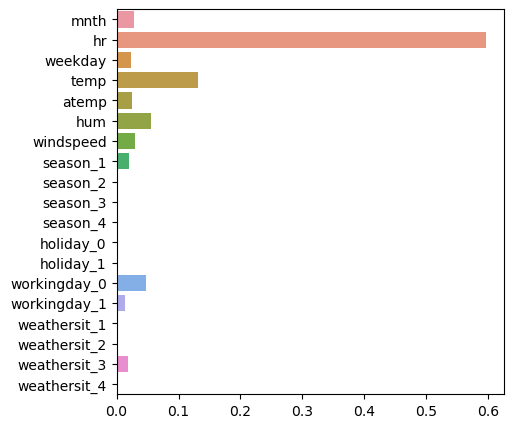

In [29]:
fig = plt.figure(figsize=(5,5))
sns.barplot(x=dtr.feature_importances_, y=X_train.columns)

From the plots above, we can see that the most important feature is hour of the day.

## Method 4. Random Forest

In [30]:
from sklearn.ensemble import RandomForestRegressor

# Fit the model and make prediction
rf = RandomForestRegressor(random_state=seed) # Default parameters
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluate the model
cross_score = np.mean(cross_val_score(rf, X_train, y_train, cv=10))
train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)

print('Training set {:.4f}'.format(train_score))
print('Cross-validated score: {:.4f}'.format(cross_score))
print('Test set: {:.4f}'.format(test_score))

Training set 0.9810
Cross-validated score: 0.8631
Test set: 0.8647


From the default models we earlier have fitted, this gives the best goodness of fit. Therefore, I will fine-tune the parameters in order to see if we can improve the score.

In [31]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


cv_search = GridSearchCV(rf, param_grid, cv=5, verbose=True, n_jobs=-1).fit(X_train, y_train)
print("best parameters:", cv_search.best_params_)
#best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Fitting 5 folds for each of 135 candidates, totalling 675 fits
best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [32]:
print('Training set {:.4f}'.format(cv_search.best_estimator_.fit(X_train, y_train).score(X_train, y_train)))
print('Cross-validated score: {:.4f}'.format(cv_search.best_score_))
print('Test set: {:.4f}'.format(cv_search.best_estimator_.score(X_test, y_test)))

Training set 0.9650
Cross-validated score: 0.8597
Test set: 0.8631


The fine-tuned random forest model

## Method 7. Support Vector Machine

In [43]:
from sklearn.svm import SVR

# Fine-tune
svr = SVR()
svr.fit(X_train, y_train)

# Evaluate model
cross_score = np.mean(cross_val_score(svr, X_train, y_train, cv=10))
train_score = svr.score(X_train, y_train)
test_score = svr.score(X_test, y_test)

print('Training set {:.4f}'.format(train_score))
print('Cross-validated score: {:.4f}'.format(cross_score))
print('Test set: {:.4f}'.format(test_score))

Training set 0.3393
Cross-validated score: 0.3329
Test set: 0.3558


## Method 8. Neural Networks

In [47]:
from keras.models import Sequential
from keras.layers import Dense

# Define model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# Compile and fit model
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), verbose=0)

In [55]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)
r_squared = r2_score(y_test, y_pred)


print('Test performance: {:.4f}'.format(r_squared))

109/109 [==============================] - 0s 2ms/step
Test performance: 0.7188


The r-squared value from the neural network model did not perform better than the earlier models.

## Conclusion

The model that performed the best, was the fine-tuned random forest model which got a score of:
Training set 0.9650
Cross-validated score: 0.8597
Test set: 0.8631